# Exercise 3 – Interpretation von Modellen

### c) Welche Charakteristika eines weiblichen Krebses in `crabs.txt` finden männliche Krebs (sogenannte Satellites auf Englisch) anziehend? Schätzen Sie die Anzahl der männlichen Krebse in Test-Datensatz anhand der Charakteristika der weiblichen Krebse. Baseline: Poisson Regression.

### Importieren der Bibliotheken

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  # for parallel coordinates
import sklearn.preprocessing  # for normalization

from module.poisson_regression import PoissonRegression
import sklearn.model_selection as ms

from sklearn import svm  # for SVM classification
from module.poisson_regression import PoissonRegression
from module.beta_regression import BetaRegression
from sklearn.model_selection import cross_val_score  # cross validation
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet, SGDRegressor
from sklearn.utils import shuffle

### Einlesen des Datensatzes

In [2]:
data = pd.read_csv('./data/crabs.txt', sep="\s+", header=None)  # whitespaces as seperators
data.columns = ["ID", "Color", "Spine", "Width", "Weight", "Sallite"]  # define column names

### Vertrautmachen mit den Daten

In [3]:
data.shape

(173, 6)

Die Daten umfassen 173 weibliche Pfeilschwanzkrebse. Zu jedem Krebs wird die Helligkeit (color), der Zustand des Rückens (spine), die Breite des Panzers (width), das Gewicht (weight) sowie die Anzahl der männlichen Anhänger (sallite) angegeben.

In [4]:
data = data.sort_values("Sallite", ascending=False)
data.head()  # show the crabs with most sallites

,ID,Color,Spine,Width,Weight,Sallite
100,101,2,3,28.3,3.00,15
47,48,2,1,26.0,2.30,14
158,159,4,3,29.3,3.23,12
132,133,2,3,28.2,3.05,11
60,61,2,3,29.0,3.20,10


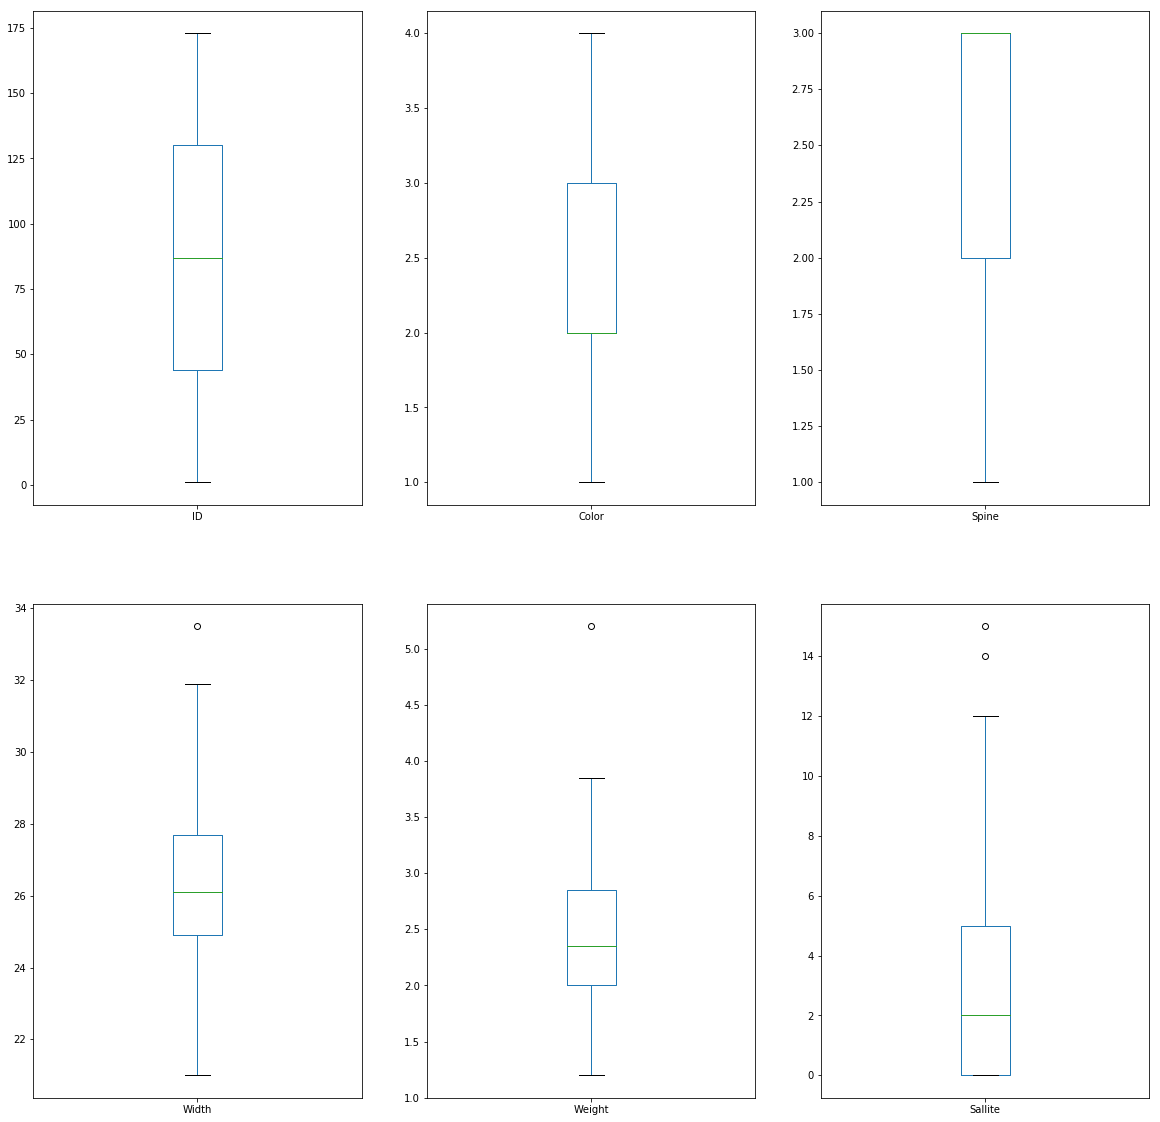

In [5]:
data.plot(figsize = (20,20), kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False);  # show boxplots

Die Kraben mit den meisten männlichen Anhängern haben in der Regel eine Durchschnittliche Färbung, der Zustand des Rückens ist gut, der Panzer relativ breit und das Gewicht relativ hoch. Um einen besseren Überblick zu schaffen werden im Folgenden parallele Koordinaten und eine Scatter-Matrix dargestellt.

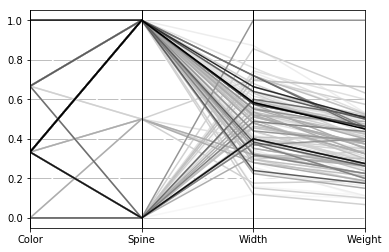

In [6]:
x = data.values
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)  # transform all variables into uniform range between 1 and 0
scaledData = pd.DataFrame(x_scaled)
scaledData.columns = data.columns
scaledData=scaledData.sort_values('Sallite')

ax = pd.plotting.parallel_coordinates(scaledData, 'Sallite', cols=["Color", "Spine", "Width", "Weight"], colormap='Greys')
ax.legend().remove()

Die Daten werden vor der Darstellung in den Bereich zwischen 0 und 1 transformiert, damit man Unterschiede bestmöglich erkennen kann. Alle Spalten nutzen dieselbe Skalierung. Krabben mit einer höheren Anzahl von Männchen entsprechen dunkelere Linien in den parallelen Koordinaten.

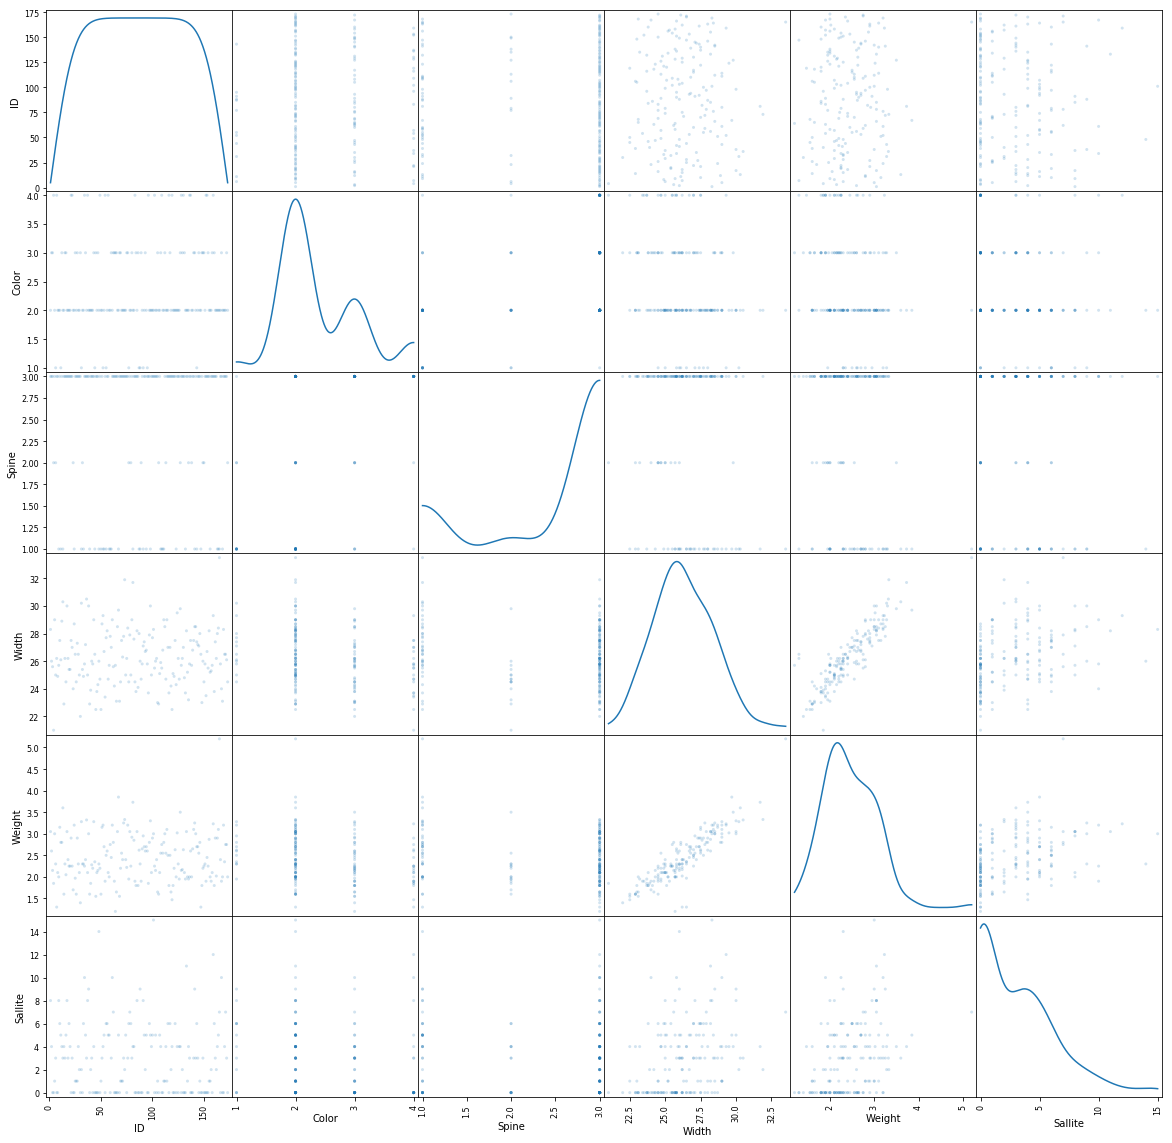

In [7]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal='kde');

Es lässt sich klar eine Korrelation zwischen der Breite und dem Gewicht der Krabben erkennen. Die meisten Krabben haben nur wenige Partner, wenige Krabben haben sehr viele, bis zu 15, Männchen.

### Schätzen der Anzahl männlicher Krebse

In [8]:
data = data.sample(frac=1).reset_index(drop=True) # shuffle data before split
X, y = data.values[:,:-1], data.values[:,-1]

Es handelt sich um ein Regressionsproblem bei dem die Anzahl der männlichen Krebse anhand der anderen Größen geschätzt werden muss. $y$ bezeichnet die tatsächliche Anzahl der männlichen Krebse. $X$ ist die Matrix mit allen anderen Größen. Die Schätzungen werden im Folgenden mit Crossvalidation und dem negativen durchschnittlichen quadratischem Fehler validiert. Letzterer bestraft größere Abweichungen stärker als es die $L1$-Norm tuen würde.

In [9]:
reg = PoissonRegression()
scores = cross_val_score(reg, X, y, cv=6, scoring='neg_mean_squared_error')
np.average(scores)

Optimization terminated successfully.
         Current function value: 2.573043
         Iterations 8
Optimization terminated successfully.
         Current function value: 2.508410
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.547792
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.650348
         Iterations 9
Optimization terminated successfully.
         Current function value: 2.649524
         Iterations 10
Optimization terminated successfully.
         Current function value: 2.679108
         Iterations 10


-9.403189184906699

Für die Poisson-Regression wurde eine Klasse erstellt die gemäß dem Adapter-Entwurfsmuster ermöglicht die Scikitlearn Crossvalidierung zu verwenden. Sie basiert auf die Poisson-Regressionsimplementierung von dem Paket $statsmodels$. Es wird ein durchschnittlicher quadrierter Fehler von ungefähr 9,4 erreicht.

In [29]:
namesRegressions = []
namesRegressions.append(("Lasso a=1\t", Lasso(alpha=1)))
namesRegressions.append(("Lasso a=01\t", Lasso(alpha=0.1)))
namesRegressions.append(("Lasso a=001\t", Lasso(alpha=0.001)))
namesRegressions.append(("Lasso a=0001\t", Lasso(alpha=0.0001)))
namesRegressions.append(("SGD\t\t", SGDRegressor(max_iter=1000, tol=1e-3)))
namesRegressions.append(("ElasticNet\t", ElasticNet()))
namesRegressions.append(("SVM Linear C=01\t", svm.SVR(kernel='linear',C=0.1)))
namesRegressions.append(("SVM Linear C=1\t", svm.SVR(kernel='linear',C=1)))
namesRegressions.append(("SVM Linear C=10\t", svm.SVR(kernel='linear',C=10)))
namesRegressions.append(("SVM RBF C=01 G=01", svm.SVR(kernel='rbf',C=0.1, gamma=0.1)))
namesRegressions.append(("SVM RBF C=1 G=01", svm.SVR(kernel='rbf',C=1, gamma=0.1)))
namesRegressions.append(("SVM RBF C=10 G=01", svm.SVR(kernel='rbf',C=10, gamma=0.1)))
namesRegressions.append(("SVM RBF C=01 G=1", svm.SVR(kernel='rbf',C=0.1, gamma=1)))
namesRegressions.append(("SVM RBF C=1 G=1\t", svm.SVR(kernel='rbf',C=1, gamma=1)))
namesRegressions.append(("SVM RBF C=10 G=1", svm.SVR(kernel='rbf',C=10, gamma=1)))
namesRegressions.append(("SVM RBF C=01 G=10", svm.SVR(kernel='rbf',C=0.1, gamma=10)))
namesRegressions.append(("SVM RBF C=1 G=10", svm.SVR(kernel='rbf',C=1, gamma=10)))
namesRegressions.append(("SVM RBF C=10 G=10", svm.SVR(kernel='rbf',C=10, gamma=10)))
for name, reg in namesRegressions:
    scores = cross_val_score(reg, X, y, cv=6, scoring='neg_mean_squared_error')
    print(name + "\t\t" + str(np.average(scores)))

Lasso a=1			-9.171219607403932
Lasso a=01			-9.037073578599069
Lasso a=001			-8.958286849965958
Lasso a=0001			-8.9596528511881
SGD				-5.838473425238933e+25
ElasticNet			-9.028381444221704
SVM Linear C=01			-9.345505806458112
SVM Linear C=1			-9.376505642302956
SVM Linear C=10			-9.363684983672668
SVM RBF C=01 G=01		-10.400000456488451
SVM RBF C=1 G=01		-10.228288421007369
SVM RBF C=10 G=01		-11.963188435103808
SVM RBF C=01 G=1		-10.583200213231516
SVM RBF C=1 G=1			-10.410695199721443
SVM RBF C=10 G=1		-9.839102451406115
SVM RBF C=01 G=10		-10.59232828867252
SVM RBF C=1 G=10		-10.504606592127937
SVM RBF C=10 G=10		-9.981400537028625


Von den Konkurenzalgorithmen schließt Lasso am besten ab. Stochastic Gradient Descent scheint gar kein gutes Modell zu lernen. Es kann besser für Probleme mit mehr Trainingsdaten verwendet werden.

Die lineare SVM schneidet annähernd so gut ab wie die Poisson-Regression. Da das Modell die Werte tendentiös schätzt, wird es im Folgenden verwendet, um die Charakteristika der Krebsweibchen nocheinmal einzuordnen.

In [30]:
reg = svm.SVR(kernel='linear', C=0.1) # train "optimal" linear SVM for visualization  
reg.fit(X, y)
data["prediction"] = reg.predict(X)  # predict the values adding them to the data frame
data.sort_values("prediction").head()

,ID,Color,Spine,Width,Weight,Sallite,prediction
167,119,4,3,22.5,1.47,4,-0.918344
22,4,4,2,21.0,1.85,0,-0.442616
33,152,4,3,23.5,1.90,0,-0.438276
158,116,4,3,23.7,1.80,0,-0.213162
28,148,3,3,23.0,1.80,0,-0.100451


In [31]:
data.sort_values("prediction").tail()

,ID,Color,Spine,Width,Weight,Sallite,prediction
38,73,2,3,31.9,3.33,2,5.382197
84,13,2,1,30.3,3.60,3,5.488380
10,31,1,1,30.2,3.28,2,5.690423
114,81,2,1,31.7,3.73,4,5.697586
11,165,2,1,33.5,5.20,7,6.898959


Das Modell der linearen SVM lernt, dass die Farbe relativ niedrig sein muss, genau wie der Rücken. Die Breite und das Gewicht müssen relativ groß sein, damit das Weibchen viele Männchen hat.

### d) Schätzen Sie den Anteil des Rohöls im Test-Datensatz, das in Gasolin konvertiert wird, anhand anderer Indikatoren im Datensatz `gasoline.csv`. Baseline: Beta Regression

# Todo: Texte an neue Ergebnisse anpassen

### Einlesen der Daten

In [47]:
data = pd.read_csv('./data/gasoline.csv', sep=";", decimal=",")

### Vertrautmachen mit den Daten

In [48]:
data.shape

(32, 7)

In [49]:
data.describe()

,Unnamed: 0,yield,gravity,pressure,temp10,temp,batch
count,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000
mean,16.500000,0.196594,39.250000,4.18125,241.500000,332.093750,5.250000
std,9.380832,0.107224,5.635429,2.61983,37.541375,69.755961,2.884888
min,1.000000,0.028000,31.800000,0.20000,190.000000,205.000000,1.000000
25%,8.750000,0.116500,36.625000,1.80000,217.000000,274.500000,3.000000
50%,16.500000,0.178000,40.000000,4.80000,231.000000,349.000000,5.000000
75%,24.250000,0.270500,40.925000,6.10000,268.750000,383.000000,7.250000
max,32.000000,0.457000,50.800000,8.60000,316.000000,444.000000,10.000000


In [50]:
data.head()

,Unnamed: 0,yield,gravity,pressure,temp10,temp,batch
0,1,0.122,50.8,8.6,190,205,1
1,2,0.223,50.8,8.6,190,275,1
2,3,0.347,50.8,8.6,190,345,1
3,4,0.457,50.8,8.6,190,407,1
4,5,0.080,40.8,3.5,210,218,2


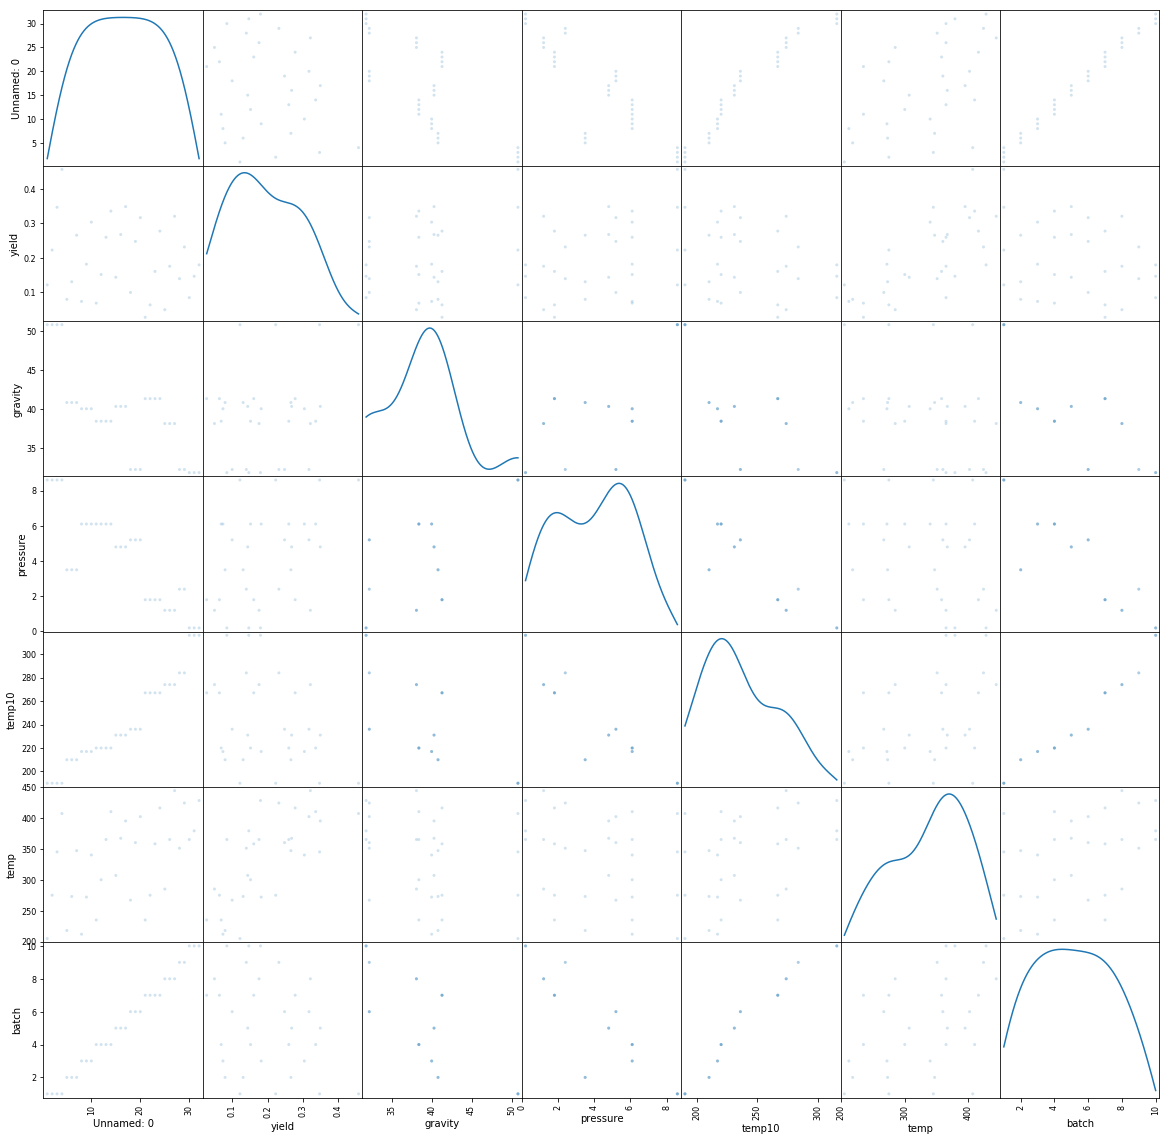

In [51]:
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(20, 20), diagonal='kde'); # create boxplot

In [62]:
X, y = data.values[:,2:], data.values[:,1]
X, y = shuffle(X, y, random_state=0)

In [63]:
clf = BetaRegression()
scores = cross_val_score(clf, X, y, cv=2, scoring='neg_mean_squared_error')
np.mean(scores)

-0.0024673389097484297

Das Modell der Beta-Regression wird analog zur Poisson-Regression mittels der $statsmodels$-Bibliothek implementiert und gemäß Adapter-Entwurfsmuster für die Evaluation kompatibel gemacht. Es ergibt sich ein mittlerer quadratischer Fehler von 0.0025.

In [64]:
namesRegressions = []
namesRegressions.append(("Lasso a=1\t", Lasso(alpha=1)))
namesRegressions.append(("Lasso a=01\t", Lasso(alpha=0.1)))
namesRegressions.append(("Lasso a=001\t", Lasso(alpha=0.001)))
namesRegressions.append(("Lasso a=0001\t", Lasso(alpha=0.0001)))
namesRegressions.append(("SGD\t\t", SGDRegressor(max_iter=1000, tol=1e-3)))
namesRegressions.append(("ElasticNet\t", ElasticNet()))
namesRegressions.append(("SVM Linear C=01\t", svm.SVR(kernel='linear',C=0.1)))
namesRegressions.append(("SVM Linear C=1\t", svm.SVR(kernel='linear',C=1)))
namesRegressions.append(("SVM Linear C=10\t", svm.SVR(kernel='linear',C=10)))
namesRegressions.append(("SVM RBF C=01 G=01", svm.SVR(kernel='rbf',C=0.1, gamma=0.1)))
namesRegressions.append(("SVM RBF C=1 G=01", svm.SVR(kernel='rbf',C=1, gamma=0.1)))
namesRegressions.append(("SVM RBF C=10 G=01", svm.SVR(kernel='rbf',C=10, gamma=0.1)))
namesRegressions.append(("SVM RBF C=01 G=1", svm.SVR(kernel='rbf',C=0.1, gamma=1)))
namesRegressions.append(("SVM RBF C=1 G=1\t", svm.SVR(kernel='rbf',C=1, gamma=1)))
namesRegressions.append(("SVM RBF C=10 G=1", svm.SVR(kernel='rbf',C=10, gamma=1)))
namesRegressions.append(("SVM RBF C=01 G=10", svm.SVR(kernel='rbf',C=0.1, gamma=10)))
namesRegressions.append(("SVM RBF C=1 G=10", svm.SVR(kernel='rbf',C=1, gamma=10)))
namesRegressions.append(("SVM RBF C=10 G=10", svm.SVR(kernel='rbf',C=10, gamma=10)))
for name, reg in namesRegressions:
    scores = cross_val_score(reg, X, y, cv=2, scoring='neg_mean_squared_error')
    print(name + "\t\t" + str(np.average(scores)))

Lasso a=1			-0.0028574941012875386
Lasso a=01			-0.000757620647835824
Lasso a=001			-0.0006005088743227335
Lasso a=0001			-0.0006155108332771303
SGD				-4.601747054725031e+28
ElasticNet			-0.0013378040896558589
SVM Linear C=01			-0.004984579268705432
SVM Linear C=1			-0.004984579268705432
SVM Linear C=10			-0.004984579268705432
SVM RBF C=01 G=01		-0.011226113510437459
SVM RBF C=1 G=01		-0.011452295128384353
SVM RBF C=10 G=01		-0.011452295128384353
SVM RBF C=01 G=1		-0.011226093749999999
SVM RBF C=1 G=1			-0.011452263888888887
SVM RBF C=10 G=1		-0.011452263888888887
SVM RBF C=01 G=10		-0.011226093749999999
SVM RBF C=1 G=10		-0.011452263888888887
SVM RBF C=10 G=10		-0.011452263888888887


Die Lasso-Regression schlägt sich deutlich besser. Die SVM-Regressionsmodelle funktionieren nicht so gut.